In [1]:
import os
# import models
import pandas as pd
import heartpy as hp
import data_utils as utils
import matplotlib.pyplot as plt

# Loading Empatica Data

## Loading Pilot Dataset

In [2]:
utils.check_if_files_unzipped('pilot')

Data already unzipped
Data path exists: pilot


In [3]:
data_path = "{0}/pilot".format(os.getcwd())

In [4]:
participants = os.listdir(data_path)

In [5]:
participants

['7', '1', '8', '6', '3', '5', '10', '9', '4', '0', '2']

In [15]:
step = 8 # this is number of samples between start of extracted snippets
sampling = 64 # this is sample rate of the device, in case of empatica this is 64 Hz
seconds = 30 # the length of the extracted signal snippet in seconds
window =  seconds *  sampling
x_train, y_train = utils.cogwear_pilot_load_dataset(data_path, participants[:-2], step=step, device='empatica', physioparam="bvp",
                                                    sampling=sampling, window=window)

In [16]:
x_train.shape, y_train.shape

((30639, 1920), (30639,))

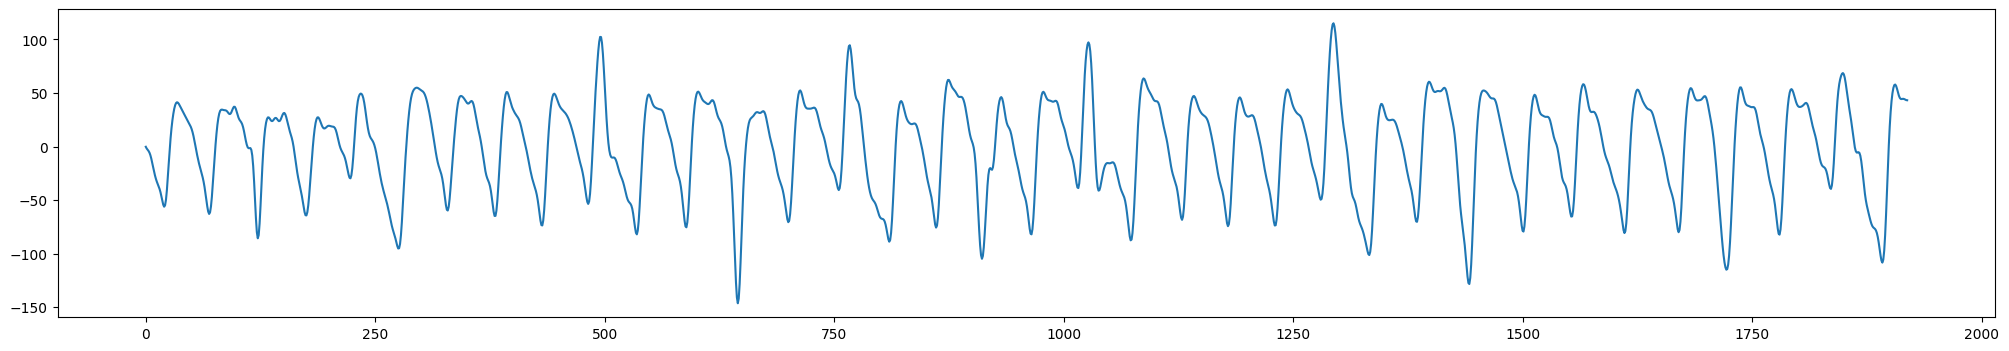

The class: 1.0


In [ ]:
i = 20000
plt.figure(figsize=(25, 4))
plt.plot(x_train[i])
plt.show()
print("The class: {0}".format(y_train[i]))
# 0 is baseline and 1 is cognitive load 

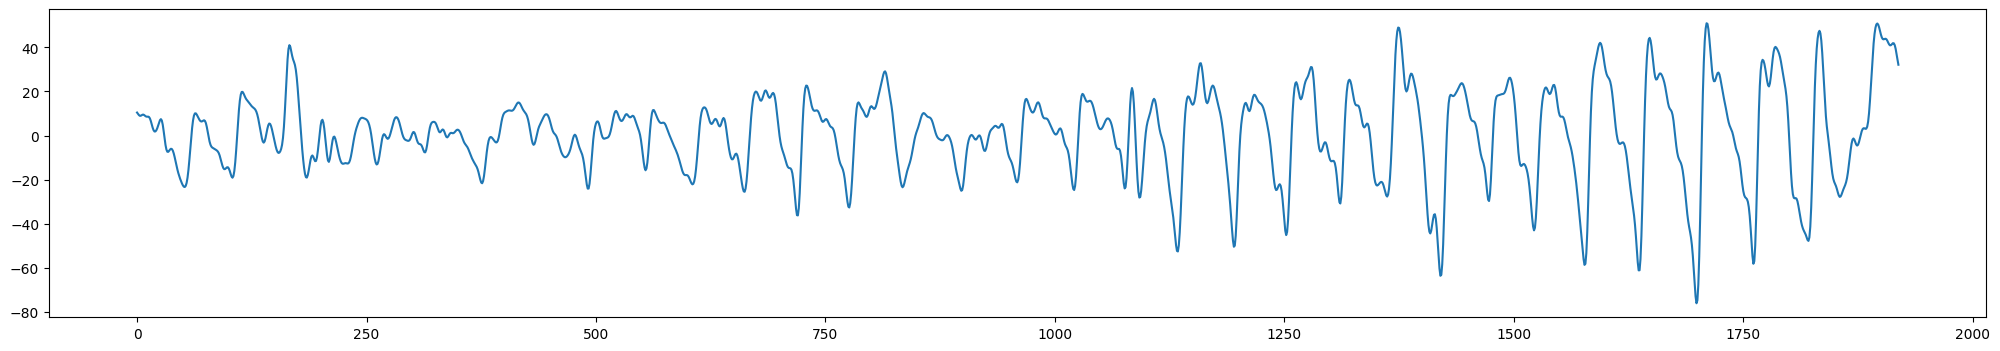

The class: 1.0


In [ ]:
i = 23500
plt.figure(figsize=(25, 4))
plt.plot(x_train[i])
plt.show()
print("The class: {0}".format(y_train[i]))
# 0 is baseline and 1 is cognitive load 

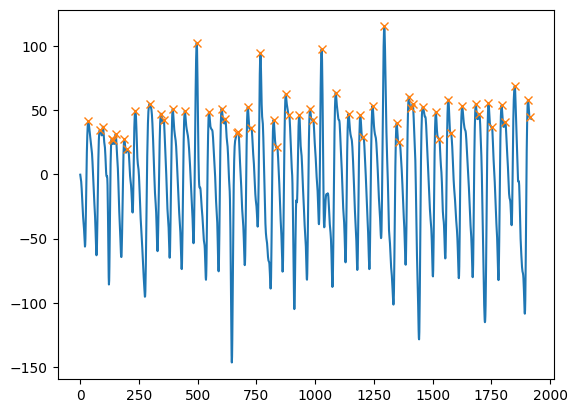

In [ ]:
i= 20000
signal = x_train[i]
from scipy.signal import find_peaks
plt.plot(signal)
peaks, _ = find_peaks(signal, height=1)
plt.plot(peaks, signal[peaks], "x")

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import ttest_ind
import pandas as pd

# --- Feature Extraction ---
def extract_features(x):
    peaks, _ = find_peaks(x, height=0.2)  # tweak height if needed
    auc = np.sum(np.abs(x))
    rms = np.sqrt(np.mean(x**2))
    std = np.std(x)
    max_amp = np.max(x)
    slope = np.polyfit(np.arange(len(x)), x, 1)[0]
    return [len(peaks), auc, rms, std, max_amp, slope]

# --- Apply to all windows ---
X_feat = np.array([extract_features(x) for x in x_train])
y = np.array(y_train)

# --- Separate groups ---
X_baseline = X_feat[y == 0]
X_cogload = X_feat[y == 1]

# --- Perform t-tests ---
feature_names = ['peak_count', 'AUC', 'RMS', 'STD', 'max_amp', 'slope']
t_results = []

for i, name in enumerate(feature_names):
    tstat, pval = ttest_ind(X_baseline[:, i], X_cogload[:, i], equal_var=False)
    t_results.append((name, tstat, pval))

# --- Output as DataFrame ---
df_results = pd.DataFrame(t_results, columns=['Feature', 't-statistic', 'p-value'])
df_results['Significant (<0.05)'] = df_results['p-value'] < 0.05

print(df_results.to_string(index=False))


   Feature  t-statistic       p-value  Significant (<0.05)
peak_count    -5.246755  1.559583e-07                 True
       AUC   -15.836876  2.898033e-56                 True
       RMS   -27.372770 5.452661e-163                 True
       STD   -27.371921 5.577894e-163                 True
   max_amp   -69.779539  0.000000e+00                 True
     slope     0.000550  9.995608e-01                False


In [8]:
step = 8 # this is number of samples between start of extracted snippets
sampling = 4 # this is sample rate of the device, in case of empatica this is 64 Hz
seconds = 30 # the length of the extracted signal snippet in seconds
window =  seconds *  sampling
x_train, y_train = utils.cogwear_pilot_load_dataset(data_path, participants[:-2], step=step, device='empatica', physioparam="eda", sampling=sampling, window=window)

In [10]:
x_train.shape, y_train.shape

((1923, 120), (1923,))

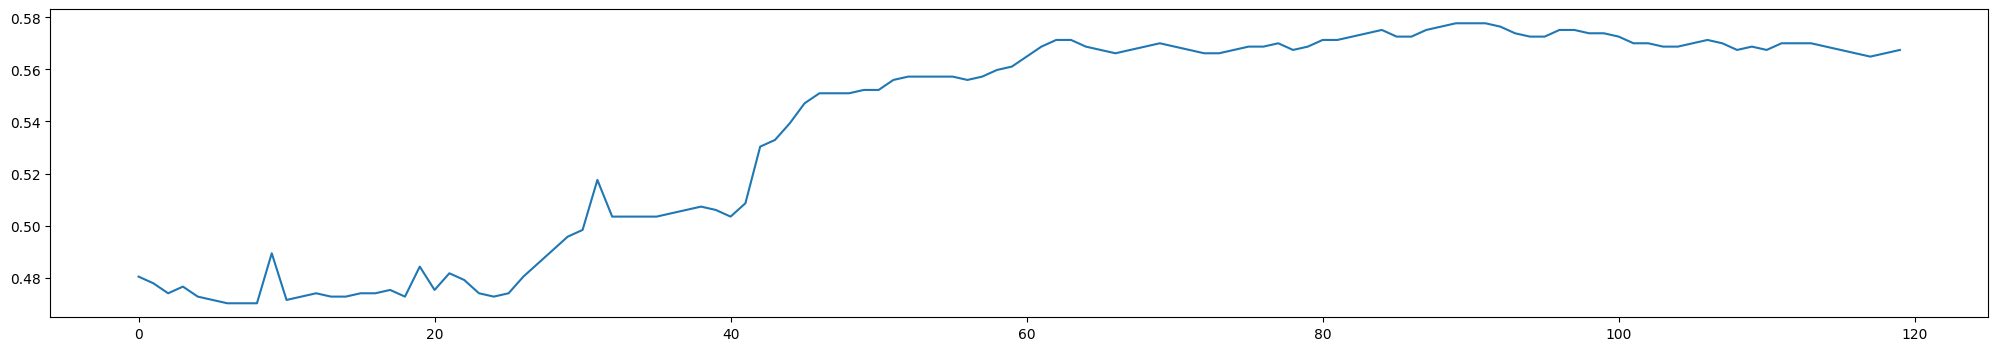

The class: 0.0


In [13]:
i = 1900
plt.figure(figsize=(25, 4))
plt.plot(x_train[i])
plt.show()
print("The class: {0}".format(y_train[i]))
# 0 is baseline and 1 is cognitive load 

## Loading Empatica PPG signal from Gamification Experiment


In [10]:
survey_data_path = 'survey_gamification/survey_gamification'
utils.check_if_files_unzipped(survey_data_path)

Data already unzipped
Data path exists: survey_gamification/survey_gamification


In [11]:
survey_exp_participants = os.listdir(survey_data_path)

In [12]:
survey_exp_participants

['22', '15', '14', '12', '24', '17', '23', '11', '20', '13', '21', '18', '16']

### Loading data capture during calibration tasks

In [13]:
cond = 'pre' #there are two sessions 'pre' and 'post'
cognitiveLoad, baseline = utils.cogwear_survey_load_participant_calibration(survey_data_path, survey_exp_participants[0],
                                              cond, device='empatica', sampling_frequency=sampling)

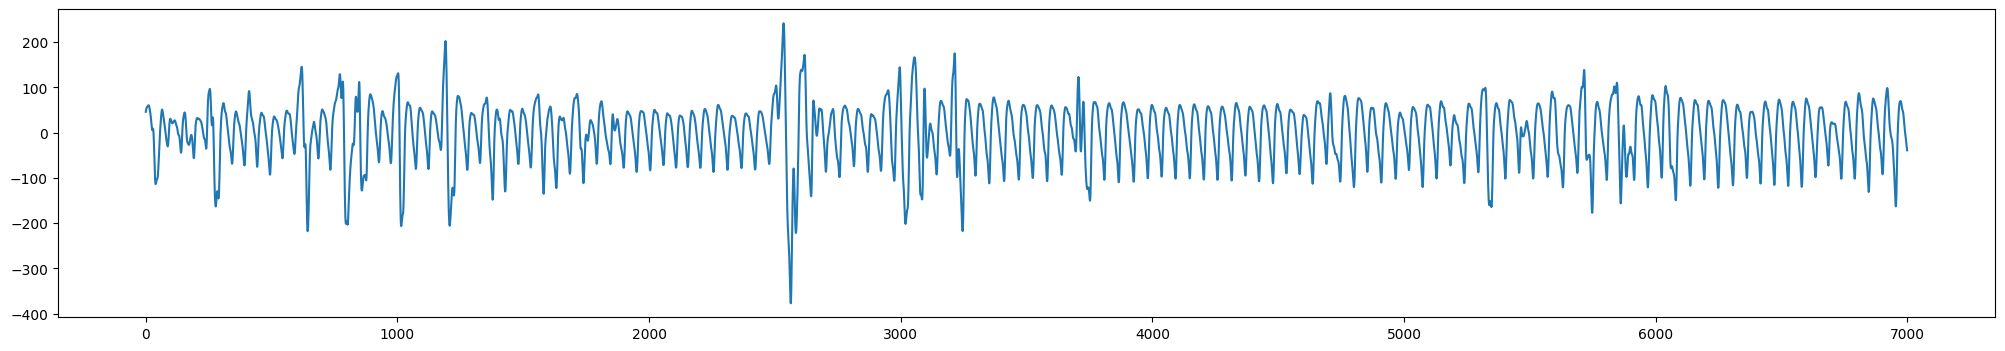

In [14]:
plt.figure(figsize=(25, 4))
plt.plot(cognitiveLoad[1000:8000])
plt.show()


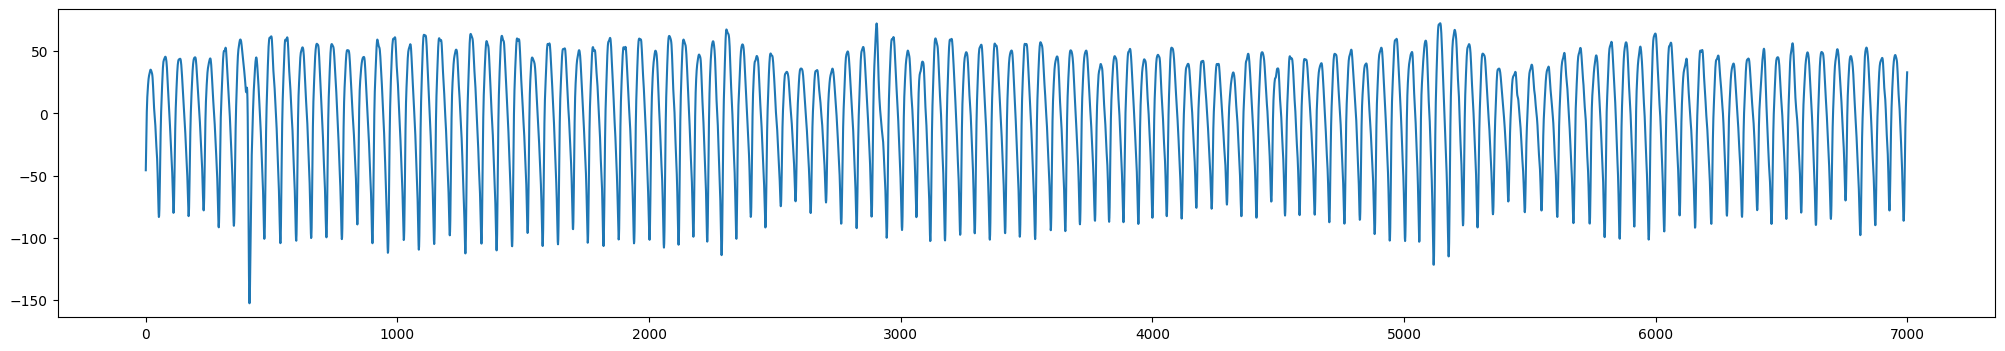

In [15]:
plt.figure(figsize=(25, 4))
plt.plot(baseline[1000:8000])
plt.show()

### Loading data captured during mobile survey completion

In [16]:
survey_bvp_signal = pd.read_csv('{0}/{1}/{2}/survey/empatica_bvp.csv'.format(survey_data_path,
                                                                             survey_exp_participants[0], cond))

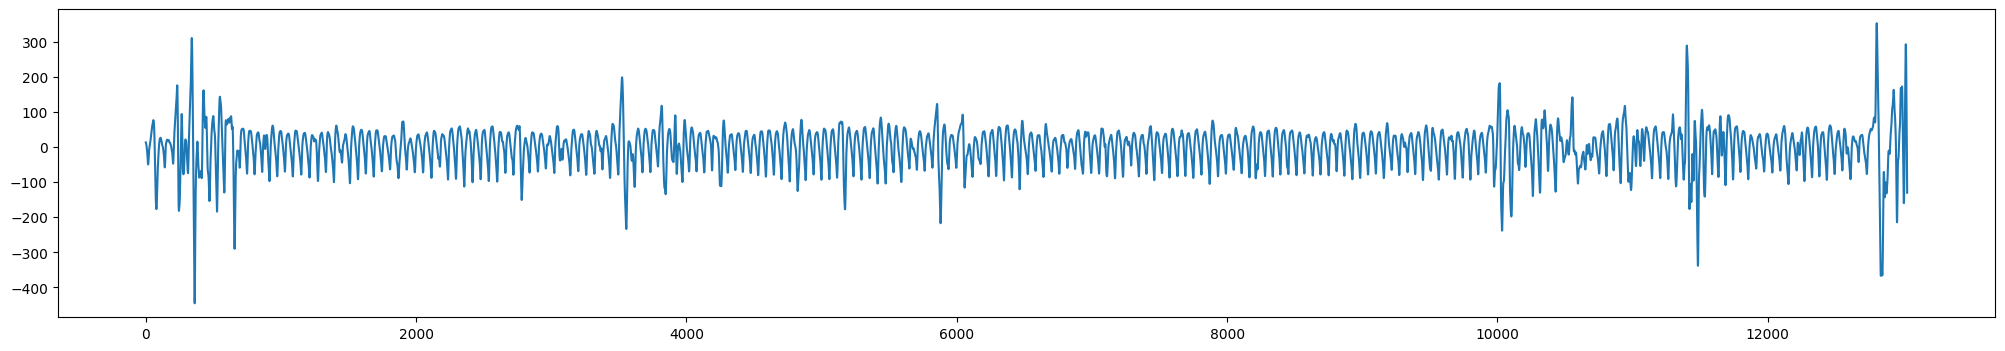

In [17]:
plt.figure(figsize=(25, 4))
plt.plot(survey_bvp_signal.bvp.values)
plt.show()

# Simple 1D CNN Model

In [18]:
number_of_channels = 1
number_of_classes_to_predict = 2
model = models.create_model('baseline', window, number_of_channels, number_of_classes_to_predict, lr=0.001)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1918, 16)          64        
                                                                 
 conv1d_1 (Conv1D)           (None, 1916, 8)           392       
                                                                 
 dropout (Dropout)           (None, 1916, 8)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 958, 8)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7664)              0         
                                                                 
 dense (Dense)               (None, 30)                229950    
                                                        